In [198]:
import os
import scanpy as sc
import numpy as np
import torch
from torch_geometric.data import Data, Dataset
from scipy.sparse import csr_matrix
import rootutils
rootutils.setup_root(os.getcwd(), indicator=".project-root", pythonpath=True)
from src.data.spatial_omics_datamodule import SpatialOmicsDataModule
from src.models.bgrl_module import BGRLLitModule
from src.utils.clustering_utils import set_leiden_resolution
from torchmetrics.clustering import NormalizedMutualInfoScore, AdjustedRandScore

def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(2092000)

In [199]:
datamodule = SpatialOmicsDataModule(
    data_dir="../data/domain/raw", 
    processed_dir="../data/domain/processed_knn_baseline/",
    redo_preprocess=False
    )

datamodule.prepare_data()
datamodule.setup()
test_dataloder = datamodule.test_dataloader()

for batch in test_dataloder:
    print(batch.sample_name[0])
    print(batch.x.shape)

BaristaSeq1
torch.Size([1512, 50])
MERFISH_small1
torch.Size([5488, 50])
STARmap4
torch.Size([1088, 50])
STARmap2
torch.Size([1049, 50])
STARmap3
torch.Size([1053, 50])
MERFISH_small5
torch.Size([5543, 50])
MERFISH_small4
torch.Size([5803, 50])
STARmap1
torch.Size([1207, 50])
BaristaSeq3
torch.Size([1627, 50])
MERFISH_small3
torch.Size([5926, 50])
MERFISH_small2
torch.Size([5557, 50])
BaristaSeq2
torch.Size([2017, 50])


In [200]:
desired_sample_name = "MERFISH_small4"
#desired_sample_name = "Zhuang-ABCA-4.002"
batch = None

for b in test_dataloder:
    if b.sample_name[0] == desired_sample_name:
        batch = b
        break

print(batch)
print(batch.sample_name)

DataBatch(x=[5803, 50], edge_index=[2, 139722], edge_weight=[139722], sample_name=[1], batch=[5803], ptr=[2])
['MERFISH_small4']


In [201]:
#checkpoint_path = "../logs/train_domain/runs/2025-03-31_15-41-12/checkpoints/epoch_011.ckpt"
checkpoint_path = "../logs/augmentation/runs/2025-04-01_12-34-30/checkpoints/epoch_011.ckpt"
#checkpoint_path = "../logs/abca/runs/2025-04-02_17-10-41/checkpoints/epoch_008.ckpt"
model = BGRLLitModule.load_from_checkpoint(checkpoint_path).net.online_encoder
model

/Users/michel/miniconda3/envs/augmentation/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


TwoLayerGCN(
  (conv1): GCNConv(50, 32)
  (conv2): GCNConv(32, 16)
)

test/nmi: 0.5389689207077026
test/ari: 0.38984328508377075


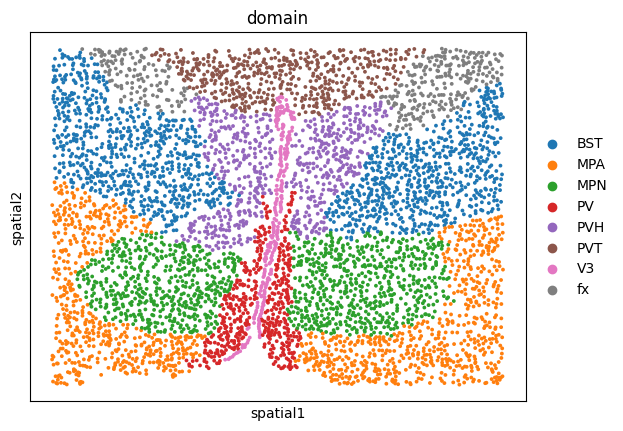

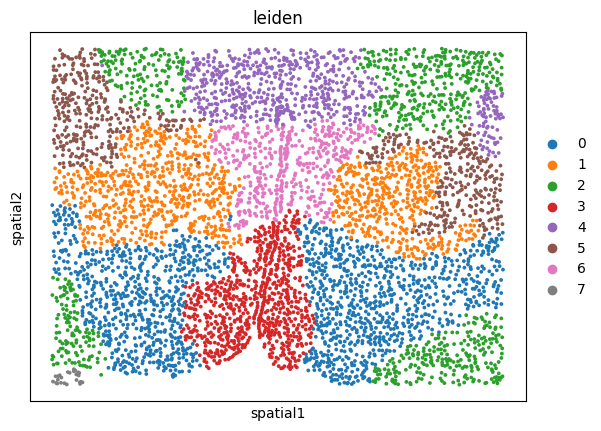

In [202]:
with torch.no_grad():
    node_embeddings = model(batch.x, batch.edge_index, batch.edge_weight)

# load adata object
sample_name = batch.sample_name[0]
file_path = os.path.join("../data/domain/processed_knn_baseline", sample_name + ".h5ad")
adata = sc.read_h5ad(file_path)

# append cell embeddings to adata object
cell_embeddings_np = node_embeddings.cpu().numpy()
adata.obsm["cell_embeddings"] = cell_embeddings_np

# get ground truth labels
domain_name = None
if sample_name.startswith("MERFISH_small"):
    domain_name = "domain"
elif sample_name.startswith("STARmap"):
    domain_name = "region"
elif sample_name.startswith("BaristaSeq"):
    domain_name = "layer"
elif sample_name.startswith("Zhuang"):
    domain_name = "parcellation_structure"
ground_truth_labels = adata.obs[domain_name]

# determine resolution based on number of ground truth labels
sc.pp.neighbors(adata, use_rep="cell_embeddings")
resolution = set_leiden_resolution(adata, target_num_clusters=ground_truth_labels.nunique())
# perform leiden clustering
sc.tl.leiden(adata, resolution=resolution)
leiden_labels = adata.obs["leiden"]

# convert ground truth labels and leiden labels to PyTorch tensors
ground_truth_labels = adata.obs[domain_name].astype("category").cat.codes
ground_truth_labels = torch.tensor(ground_truth_labels.values, dtype=torch.long)        
leiden_labels = adata.obs["leiden"].astype("category").cat.codes
leiden_labels = torch.tensor(leiden_labels.values, dtype=torch.long)

# calculate metrics
test_nmi = NormalizedMutualInfoScore()
test_ars = AdjustedRandScore()
nmi = test_nmi(ground_truth_labels, leiden_labels)
ari = test_ars(ground_truth_labels, leiden_labels)

# log metrics for each graph
print(f"test/nmi: {nmi}")
print(f"test/ari: {ari}")

sc.pl.embedding(adata, basis="spatial", color=domain_name, size=30)
sc.pl.embedding(adata, basis="spatial", color="leiden", size=30)

In [283]:
merfish4 = sc.read_h5ad("../logS/augmentation/runs/2025-04-06_17-57-24/adata_files/MERFISH_small4.h5ad")
merfish5 = sc.read_h5ad("../logS/augmentation/runs/2025-04-06_17-57-24/adata_files/MERFISH_small5.h5ad")

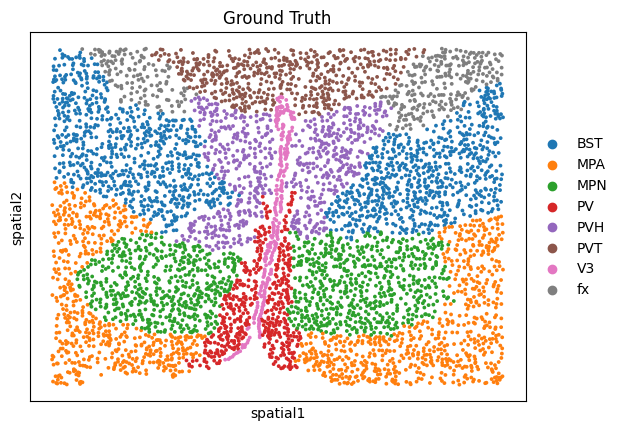

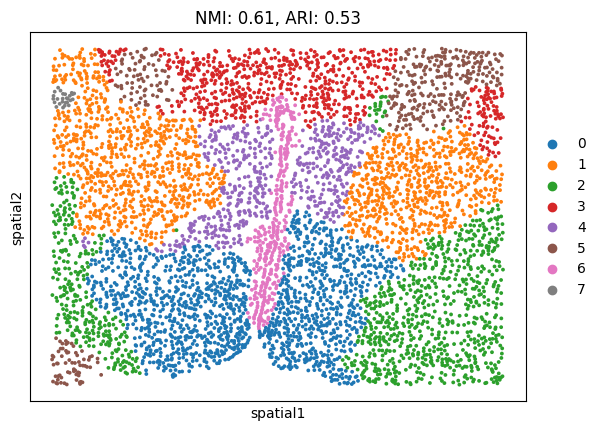

In [280]:
sc.pl.embedding(merfish4, basis="spatial", color="domain", size=30, title="Ground Truth")
sc.pl.embedding(merfish4, basis="spatial", color="leiden", size=30, title="NMI: 0.61, ARI: 0.53")

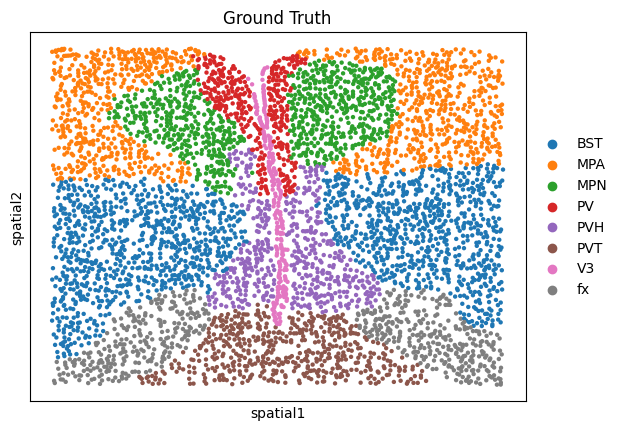

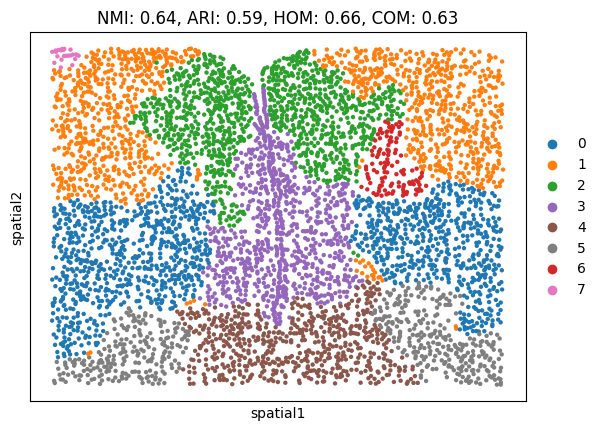

In [289]:
merfish5.obsm["spatial"] *= -1
merfish5.obsm["spatial"][:, 0] *= -1

sc.pl.embedding(merfish5, basis="spatial", color="domain", size=40, title="Ground Truth")
sc.pl.embedding(merfish5, basis="spatial", color="leiden", size=40, title="NMI: 0.64, ARI: 0.59, HOM: 0.66, COM: 0.63")

In [285]:
merfish5.uns["leiden_colors"] = [merfish5.uns["leiden_colors"][i] for i in [0, 1, 2, 4, 5, 7, 3, 6]]

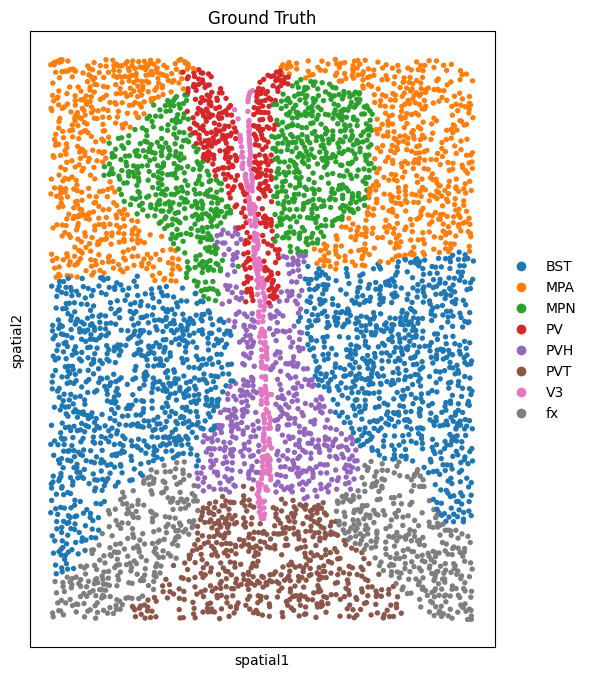

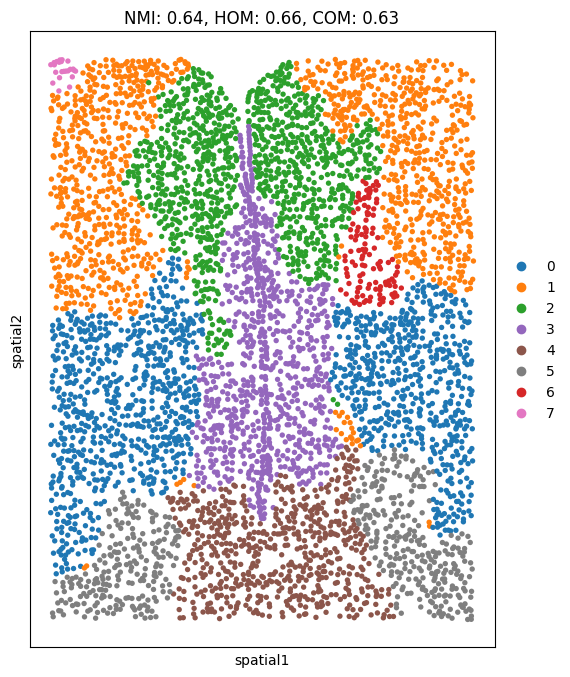

In [297]:
import matplotlib.pyplot as plt

# Flip and mirror the spatial embedding
merfish5.obsm["spatial"] *= -1
merfish5.obsm["spatial"][:, 0] *= -1

# Plot the ground truth with a custom figure size
fig, ax = plt.subplots(figsize=(6, 8))  # Adjust width and height (e.g., 6 wide, 10 tall)
sc.pl.embedding(merfish5, basis="spatial", color="domain", size=60, title="Ground Truth", ax=ax, show=False)
plt.show()

# Plot the Leiden clusters with a custom figure size
fig, ax = plt.subplots(figsize=(6, 8))  # Adjust width and height
sc.pl.embedding(merfish5, basis="spatial", color="leiden", size=60, title="NMI: 0.64, HOM: 0.66, COM: 0.63", ax=ax, show=False)
plt.show()